In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d157cc2b-e415-d7f3-ca64-d499fbd82cba)


In [2]:
#@title install package
!pip install gpytorch==1.5.1
!pip install watermark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.1/503.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [4]:

#@title import packages
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch.nn import Parameter
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import NormalPrior
from gpytorch.mlls import VariationalELBO, PredictiveLogLikelihood

import gpytorch
sns.reset_defaults()
sns.set_context(context='talk')
colors = sns.color_palette('tab10')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
def set_seed(seed):
    import numpy as np
    import random

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0)

In [6]:
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"
df = pd.read_csv(URL, index_col=0)

print('data shape:', df.shape)
print('labels:', df.index.unique().tolist())

df.head()


data shape: (437, 48)
labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


## Model setting
- observation : DNA data
- latent variables : [time, variety]

In [8]:
K=2 #dim of latent variables
N=df.shape[0] #num of samples
D=df.shape[1] #dim of observation

data = torch.tensor(df.values,dtype=torch.get_default_dtype())
y=data.t() #N*D->D*N

#log transformation : capture_time:[0,1]
capture_time=y.new_tensor([int(cell_name.split(" ")[0]) for cell_name in df.index.values]) #437
time = capture_time.log2()/6 #2^0~2^6

x_prior_mean = torch.zeros(y.size(1),K) #N*K
#first dim -> relevant to time
x_prior_mean[:,0] = time

In [9]:
class GPLVM(ApproximateGP):
  def __init__(self,n_inducing_points,n_latent_dims,n_data_dims,n_data_points):
    batch_shape=torch.Size([n_data_dims])
    #set initial value for inducing points
    inducing_points = torch.randn(n_data_dims,n_inducing_points,n_latent_dims)
    #approximate distribution
    variational_distribution=CholeskyVariationalDistribution(
        inducing_points.size(-2),batch_shape=batch_shape,
    )
    #strategy
    variational_strategy = VariationalStrategy(
        self,inducing_points,variational_distribution,
        #position for inducing points is trainable
        learn_inducing_locations=True
    )
    super(GPLVM,self).__init__(variational_strategy)
    #mean and covariance
    self.mean_module=ConstantMean(batch_shape=batch_shape)
    self.covar_module=ScaleKernel(
        RBFKernel(nu=1.5,batch_shape=batch_shape,ard_num_dims=2), #Automatic Relevance Determination" (ARD), the kernel will have a separate length scale for each of the first two input dimensions.
        batch_shape=batch_shape
    )
    #initialize x with mean of the priordistribution
    self.register_parameter(
        name="x",
        parameter=Parameter(x_prior_mean.clone())
    )
    #set prior distribution
    self.register_prior(
        name="prior_x",
        prior=NormalPrior(loc=x_prior_mean,
                          scale=torch.ones_like(x_prior_mean)),
        #name of param whose prior distribution is set
        param_or_closure="x"
    )

  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    dist = MultivariateNormal(mean_x,covar_x)
    return dist

model = GPLVM(n_inducing_points=32,n_latent_dims=K,
              n_data_dims=D,n_data_points=N)
likelihood = GaussianLikelihood(num_tasks=D,batch_shape=torch.Size([D]))

if torch.cuda.is_available():
  model = model.cuda()
  likelihood = likelihood.cuda()
  y=y.cuda()


## Train

In [10]:
model.train()
likelihood.train()

#set parameters to be optimized
optimizer = torch.optim.Adam([
    {"params":model.parameters()},
    {"params":likelihood.parameters()}
],lr=0.01)

#objective function
mll = PredictiveLogLikelihood(likelihood,model,num_data=N)

loss_list = []
iterator = tqdm(range(2000))
for i in iterator:
  #init
  optimizer.zero_grad()
  #output
  output = model(model.x)
  #loss
  loss=-mll(output,y).sum()
  loss_list.append(loss.item())
  #backward
  iterator.set_postfix(loss=loss.item())
  loss.backward(retain_graph=True)
  #update
  optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:124: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


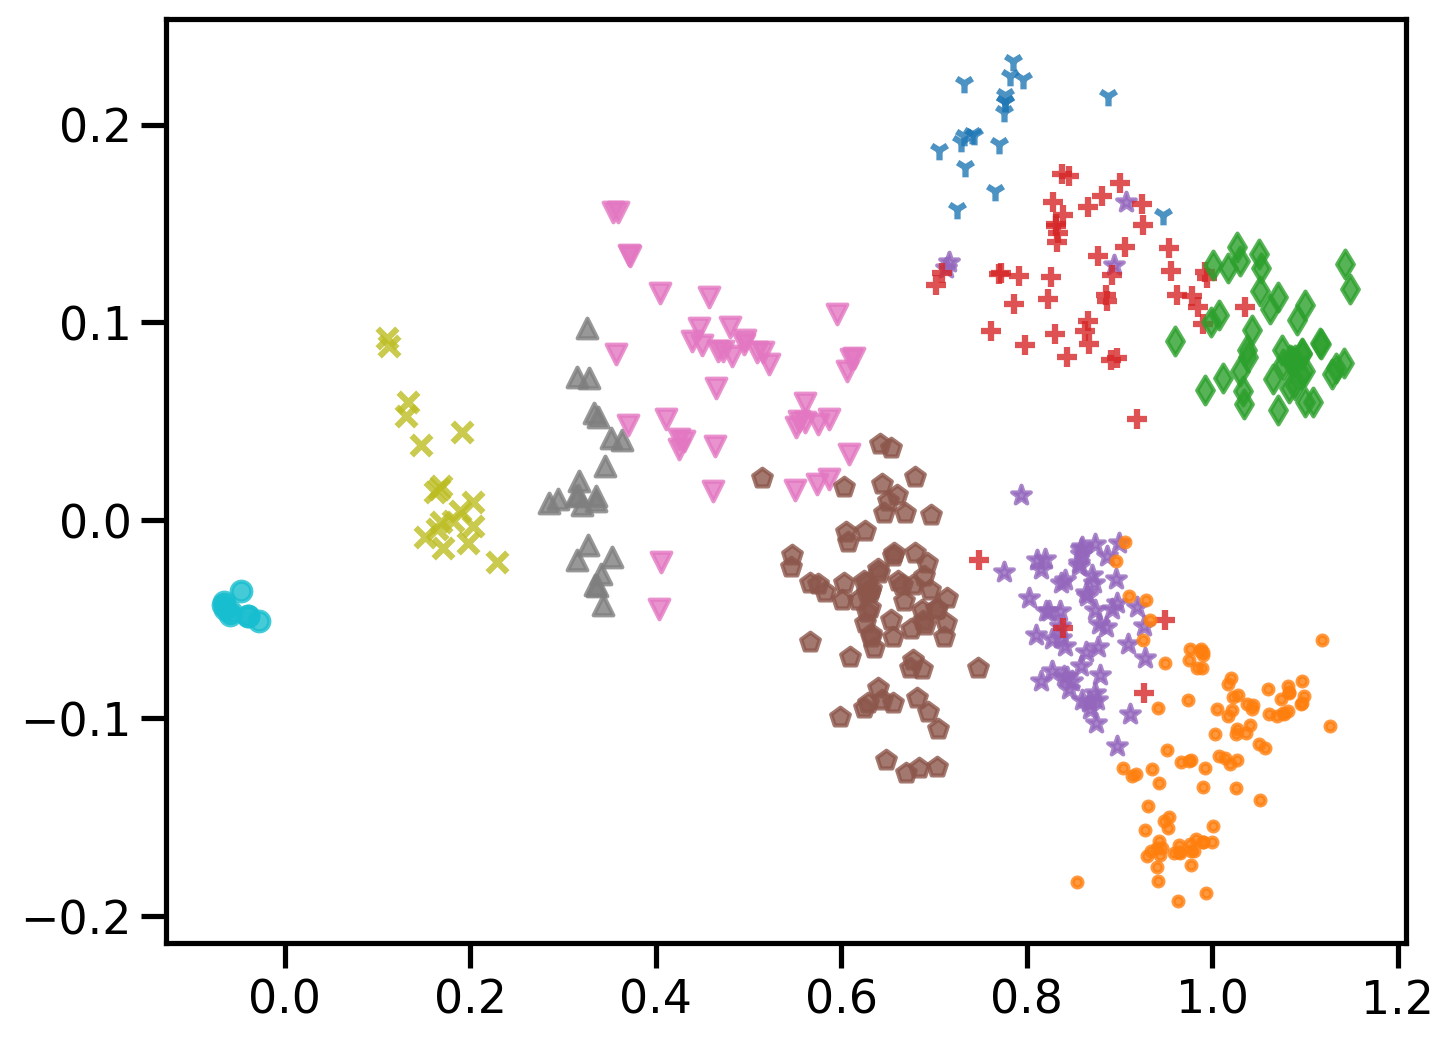

In [14]:
colors = plt.get_cmap("tab10").colors[::-1]
markers = ["o","x","^","v","p","*","+","d",".","1"]
labels=df.index.unique()
x = model.x.cpu().detach().numpy()
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
  x_i = x[df.index==label]
  plt.scatter(x_i[:,0],x_i[:,1],color=colors[i],marker=markers[i],alpha=0.8,s=50,label=labels)

Text(0.5, 1.0, 'PCA on Single-Cell qPCR data')

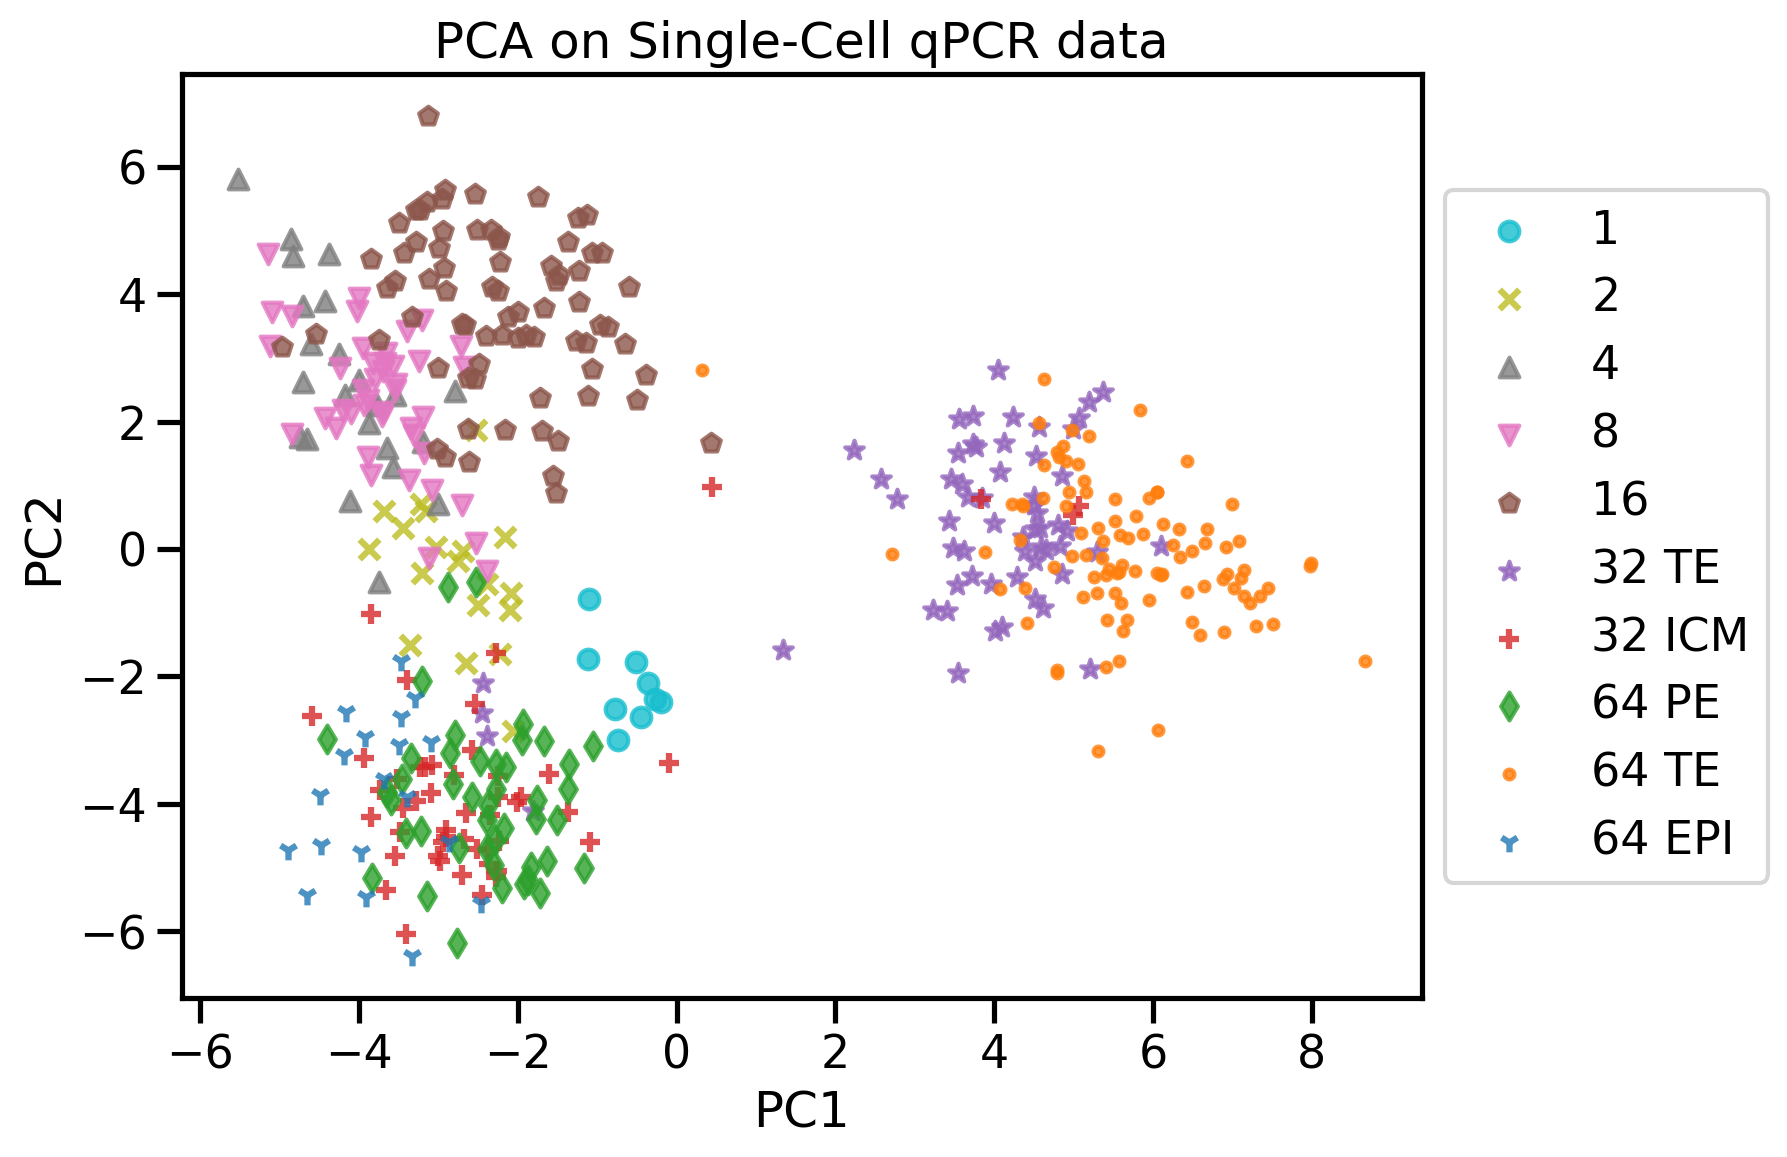

In [15]:
#@title PCA(hide)
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(data)

plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

for i, label in enumerate(labels):
    X_i = X_pca[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker=markers[i], alpha=0.8, s=50, label=label)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Single-Cell qPCR data")

Text(0.5, 1.0, 't-SNE on Single-Cell qPCR data')

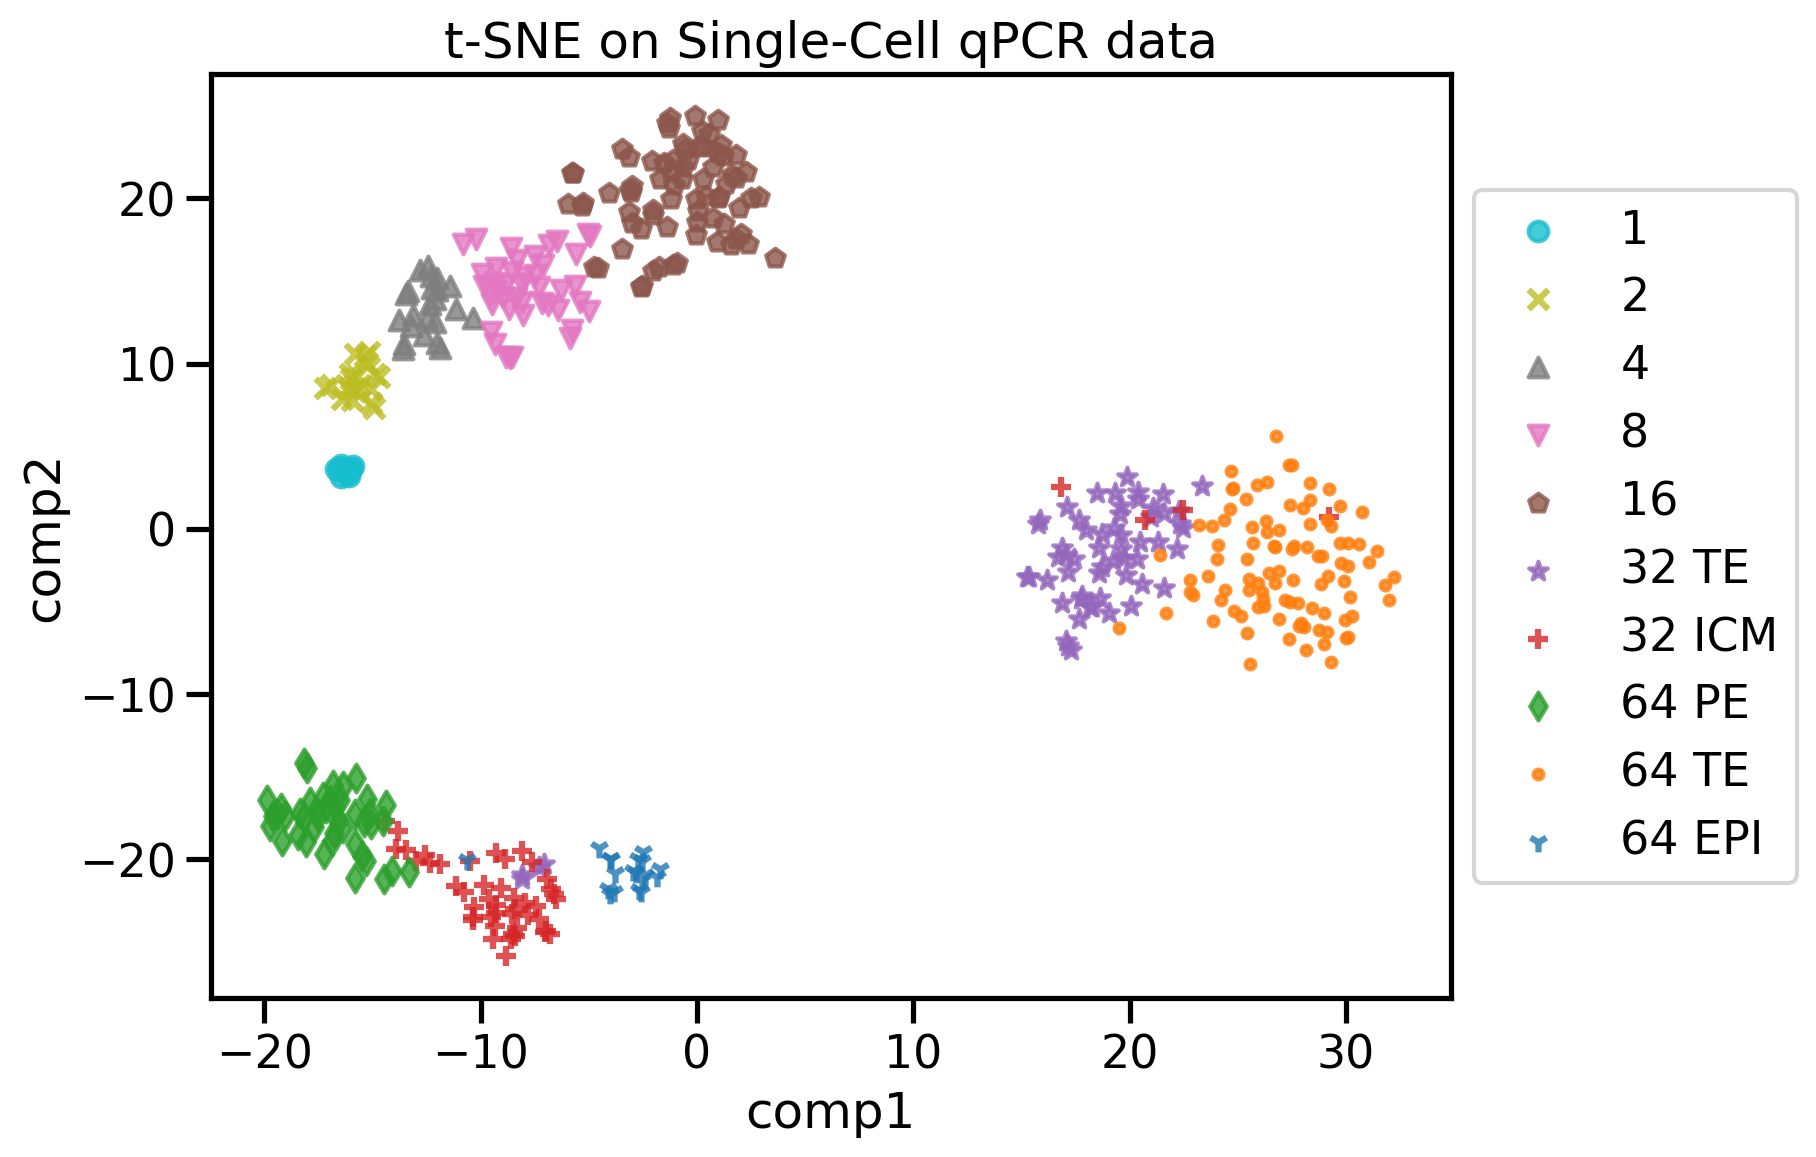

In [16]:

#@title t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(data)

plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

for i, label in enumerate(labels):
    X_i = X_tsne[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker=markers[i], alpha=0.8, s=50, label=label)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("comp1")
plt.ylabel("comp2")
plt.title("t-SNE on Single-Cell qPCR data")